In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
sys.path.append('../')
import torchvision
from gaussian_teleport.edm.dataset import ImageFolderDataset
from gaussian_teleport.edm.networks_edm import SongUNet
from gaussian_teleport.edm.train_edm import create_model, EDM, train_edm_model
from gaussian_teleport.edm_utils import get_default_config

### MNIST

In [3]:
config = get_default_config("mnist")
unet = create_model(config)
edm = EDM(model=unet, cfg=config)
edm.model.train();

In [4]:
config

{'DATASET': 'mnist',
 'channel_mult': [1, 2, 3, 4],
 'model_channels': 16,
 'attn_resolutions': [0],
 'layers_per_block': 1,
 'num_fid_sample': 5000,
 'fid_batch_size': 1024,
 'channels': 1,
 'img_size': 32,
 'device': 'cuda',
 'sigma_min': 0.002,
 'sigma_max': 80.0,
 'rho': 7.0,
 'sigma_data': 0.5,
 'spatial_matching': 'padding'}

In [7]:
img_dataset = torchvision.datasets.MNIST(root='../datasets/mnist', download=True, train=True,
                                    transform=torchvision.transforms.Compose(
                                        [torchvision.transforms.Resize(config.img_size),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))]
                                    ),)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 63015557.33it/s]


Extracting ../datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 3248215.32it/s]

Extracting ../datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 22600435.27it/s]


Extracting ../datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 6569147.85it/s]

Extracting ../datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw



In [ ]:
outdir = f"../exp_runs/MNIST_temp"
sample_dir = f"{outdir}/samples"
ckpt_dir = f"{outdir}/checkpoints"
config.outdir = outdir
config.sample_dir = sample_dir
config.ckpt_dir = ckpt_dir
for dir in [outdir, sample_dir, ckpt_dir]:
    os.makedirs(dir, exist_ok=True)

config.train_batch_size = 256
config.num_steps = 20000
config.learning_rate = 2e-4
config.train_progress_bar = True
config.total_steps = 18
config.save_images_step = 100
config.eval_batch_size = 64
config.accumulation_steps = 1
config.gt_guide_type = 'l2'
config.warmup = 1000
config.log_step = 100
config.save_model_iters = 5000

# around 1000 steps you could see some digits. 
train_edm_model(config, unet, img_dataset, device="cuda")

  0%|          | 0/20000 [00:00<?, ?it/s]

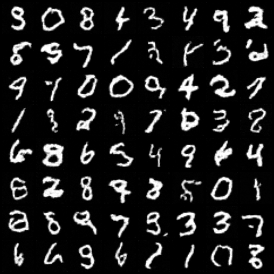

In [5]:
# %%
from IPython.display import Image
display(Image(filename='../exp_runs/MNIST_temp/samples/image_2400.png'))
# %%

### FFHQ

In [3]:
from gaussian_teleport.edm.dataset import ImageFolderDataset
import torch
import numpy as np
from os.path import join

class TransformedDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        if isinstance(item, (list, tuple)):
            # Handle case where dataset returns (image, label) or similar
            image = item[0]
            if self.transform is not None:
                if isinstance(image, np.ndarray):
                    image = torch.from_numpy(image).float() / 255.0
                image = self.transform(image)
            return (image,) + item[1:] if len(item) > 1 else (image,)
        else:
            # Handle case where dataset returns just the image
            if self.transform is not None:
                if isinstance(item, np.ndarray):
                    item = torch.from_numpy(item).float() / 255.0
                return self.transform(item)
            return item


In [4]:
config = get_default_config("ffhq64")
unet = create_model(config)
edm = EDM(model=unet, cfg=config)
edm.model.train();

In [5]:
config

{'DATASET': 'ffhq64',
 'channel_mult': [1, 2, 2],
 'model_channels': 96,
 'attn_resolutions': [16],
 'layers_per_block': 2,
 'num_fid_sample': 5000,
 'fid_batch_size': 1024,
 'channels': 3,
 'img_size': 64,
 'device': 'cuda',
 'sigma_min': 0.002,
 'sigma_max': 80.0,
 'rho': 7.0,
 'sigma_data': 0.5,
 'spatial_matching': 'padding'}

In [7]:
dataset_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
img_dataset = ImageFolderDataset(join(dataset_dir, "ffhq-64x64.zip"))
img_transformed_dataset = TransformedDataset(img_dataset, transform=torchvision.transforms.Compose(
                                        [torchvision.transforms.Resize(config.img_size),
                                            # torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))]
                                    ),)
img_transformed_dataset[0]

(tensor([[[-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8510, -0.9059, -0.9451],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8510, -0.7882, -0.7569],
          ...,
          [-0.8275, -0.8196, -0.8039,  ...,  0.1686,  0.1922,  0.1843],
          [-0.8039, -0.7882, -0.7647,  ...,  0.0980,  0.1294,  0.0824],
          [-0.8353, -0.8039, -0.7725,  ...,  0.0510,  0.0588,  0.0353]],
 
         [[ 0.0039, -0.0118, -0.0039,  ..., -0.0667, -0.1137, -0.1451],
          [-0.0275, -0.0039, -0.0275,  ...,  0.3412,  0.2078,  0.0667],
          [-0.0353, -0.0275, -0.0588,  ...,  0.5373,  0.5686,  0.5529],
          ...,
          [ 0.2078,  0.2235,  0.2235,  ...,  0.4353,  0.4667,  0.4431],
          [ 0.2314,  0.2549,  0.2784,  ...,  0.3569,  0.3725,  0.2863],
          [ 0.1922,  0.2157,  0.2549,  ...,  0.2863,  0.2863,  0.2235]],
 
         [[ 0.1373,  0.1216,  0.1294,  ...,  0.2078,  0.1765,  0.1529],
          [ 0.1137,  0.1216,

In [ ]:
outdir = f"../exp_runs/FFHQ64_temp"
sample_dir = f"{outdir}/samples"
ckpt_dir = f"{outdir}/checkpoints"
config.outdir = outdir
config.sample_dir = sample_dir
config.ckpt_dir = ckpt_dir
for dir in [outdir, sample_dir, ckpt_dir]:
    os.makedirs(dir, exist_ok=True)

config.train_batch_size = 64
config.num_steps = 20000
config.learning_rate = 2e-4
config.train_progress_bar = True
config.total_steps = 35
config.save_images_step = 100
config.eval_batch_size = 64
config.accumulation_steps = 1
config.gt_guide_type = 'l2'
config.warmup = 1000
config.log_step = 100
config.save_model_iters = 5000

# around 1000 steps you could see some digits. 
train_edm_model(config, unet, img_transformed_dataset, device="cuda")

  0%|          | 0/20000 [00:00<?, ?it/s]